<a href="https://colab.research.google.com/github/a945120/ColabforAI/blob/master/Dogsbreeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!git clone https://github.com/a945120/ColabforAI.git  連接github資料夾指令

In [1]:
!git clone https://github.com/a945120/ColabforAI.git

Cloning into 'ColabforAI'...
remote: Enumerating objects: 3560, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 3560 (delta 8), reused 1 (delta 0), pack-reused 3512
Receiving objects: 100% (3560/3560), 138.41 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (3496/3496), done.


In [2]:
#visualization
import matplotlib.pyplot as plt

#data manipulations
import numpy as np
import pandas as pd

#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models


In [3]:
from PIL import Image
from collections import OrderedDict

In [4]:
#check folder is loaded
dataset = ImageFolder('/content/ColabforAI/images modify')
print('Total Images number: ',len(dataset))
print('Total Classes number: ',len(dataset.classes))

Total Images number:  3494
Total Classes number:  20


In [5]:
#rename folder
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

print(breeds)

['Chihuahua', 'Maltese dog', 'Shih Tzu', 'papillon', 'Yorkshire terrier', 'miniature schnauzer', 'standard schnauzer', 'golden retriever', 'Labrador retriever', 'Border collie', 'German shepherd', 'Doberman', 'French bulldog', 'Siberian husky', 'Samoyed', 'Pomeranian', 'Pembroke', 'toy poodle', 'miniature poodle', 'standard poodle']


In [6]:
#random split train and test dataset
random_seed = 1
torch.manual_seed(random_seed)

train_num = 0.6
val_num = 0.2

train_size = int(len(dataset) * train_num)
data_set = len(dataset) - train_size

val_size = int(data_set / 2.0)
test_size = data_set - val_size

print(train_size, val_size, test_size)

2096 699 699


In [7]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(len(train_ds), len(val_ds), len(test_ds))

2096 699 699


n02086240-Shih-Tzu
<class 'PIL.Image.Image'>


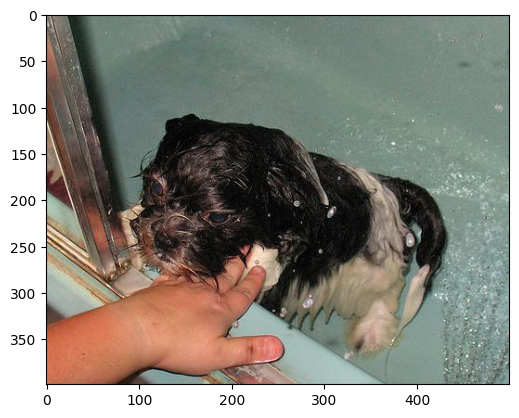

In [8]:
img, label = train_ds[10]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [9]:
class DogBreedDataset(Dataset):
  def __init__(self, ds, transform = None):
    self.ds = ds
    self.transform = transform

  def __len__(self):
    return len(self.ds)

  def __getitem__(self, idx):
    img, label = self.ds[idx]
    if self.transform:
       img = self.transform(img)
       return img, label



In [61]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),

])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

2
torch.Size([3, 224, 224])


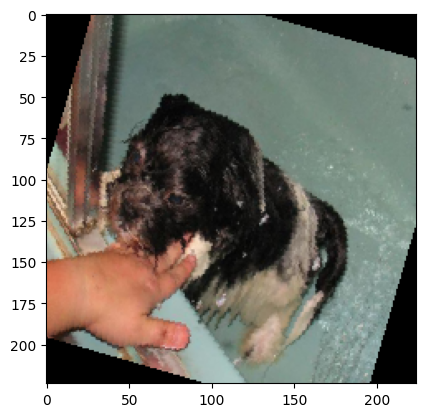

In [62]:
img, label = train_dataset[10]
print(label)
plt.imshow(img.permute(1,2,0))
print(img.shape)

In [65]:
batch_size = 64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [66]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

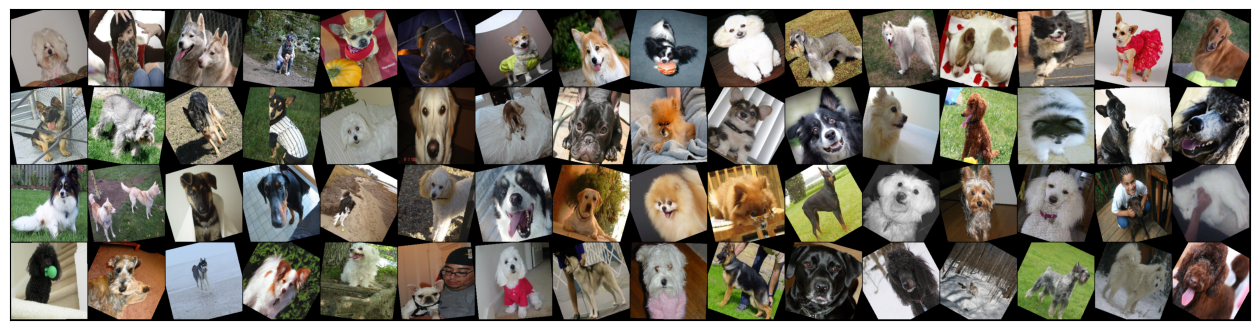

In [67]:
show_batch(train_dl)

In [68]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [69]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss

    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}

    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))


# CNN MODEL

In [17]:
'''
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),   # in_channels = 3 / out_channels = 32 / kernel_size = 3 / 224 * 224 * 32
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 32

            nn.Conv2d(32, 64, 3, stride=1, padding=1),   # 112 * 112* 64
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),    # 112 * 112* 128
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 128

            nn.Conv2d(128, 256, 3, stride=1, padding=1),   # 56*56*256
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  # 56*56*256
            nn.ReLU(),
            nn.MaxPool2d(2,2),                        # 28*28*256

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 14*14*256

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 7*7*256

            nn.Flatten(),
            nn.Linear(7*7*256, 512),
            nn.ReLU(),
            nn.Linear(512, 20),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, xb):
        return self.network(xb)
'''

'\nclass DogBreedClassificationCNN(ImageClassificationBase):\n    def __init__(self):\n        super().__init__()\n\n        self.network = nn.Sequential(\n            nn.Conv2d(3, 32, 3, stride=1, padding=1),   # in_channels = 3 / out_channels = 32 / kernel_size = 3 / 224 * 224 * 32\n            nn.ReLU(),\n            nn.Conv2d(32, 32, 3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.MaxPool2d(2, 2),                         # 112 * 112 * 32\n\n            nn.Conv2d(32, 64, 3, stride=1, padding=1),   # 112 * 112* 64\n            nn.ReLU(),\n            nn.Conv2d(64, 128, 3, stride=1, padding=1),    # 112 * 112* 128\n            nn.ReLU(),\n            nn.MaxPool2d(2,2),                          # 56 * 56* 128\n\n            nn.Conv2d(128, 256, 3, stride=1, padding=1),   # 56*56*256\n            nn.ReLU(),\n            nn.Conv2d(256, 256, 3, stride=1, padding=1),  # 56*56*256\n            nn.ReLU(),\n            nn.MaxPool2d(2,2),                        # 28*28*256\n\n 

# Wide RESNET50-2 MODEL

In [18]:
'''
class DogBreedPretrainedWideResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.wide_resnet50_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 20),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)
'''

'\nclass DogBreedPretrainedWideResnet(ImageClassificationBase):\n    def __init__(self):\n        super().__init__()\n\n        self.network = models.wide_resnet50_2(pretrained=True)\n        # Replace last layer\n        num_ftrs = self.network.fc.in_features\n        self.network.fc = nn.Sequential(\n            nn.Linear(num_ftrs, 20),\n            nn.LogSoftmax(dim=1)\n        )\n\n    def forward(self, xb):\n        return self.network(xb)\n'

# ResNet 50

In [70]:
class DogBreedPretrainedResnet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 20),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [71]:
model = DogBreedPretrainedResnet50()
model

DogBreedPretrainedResnet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

In [21]:
'''
model = DogBreedPretrainedWideResnet()
model
'''

'\nmodel = DogBreedPretrainedWideResnet()\nmodel\n'

In [22]:
'''
model = DogBreedClassificationCNN()
model
'''

'\nmodel = DogBreedClassificationCNN()\nmodel\n'

In [72]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [76]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [77]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model, device);

cuda


In [78]:
# check the model
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break

try_batch(train_dl)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([13,  3, 15, 12,  4, 19, 15,  1, 16, 10, 15, 16, 18, 13,  7, 13, 12, 13,
         2,  1,  2,  9,  4,  5, 18, 19,  3,  5, 14, 18,  1, 16,  9, 16, 15, 11,
         2, 13,  4, 10,  2,  4, 12, 15, 19,  6,  3, 19, 19, 16,  8,  2, 10,  0,
         7, 16,  5,  5, 16, 10,  1,  3,  1, 17], device='cuda:0')
outs.shape : torch.Size([64, 20])
outs :  tensor([[-3.0678, -3.7642, -3.0142,  ..., -2.7332, -3.1395, -2.5158],
        [-2.8656, -4.2108, -3.1403,  ..., -2.7911, -2.9186, -2.7883],
        [-2.6947, -3.8296, -3.2819,  ..., -2.6749, -2.9128, -2.9494],
        ...,
        [-2.7255, -3.5183, -2.9474,  ..., -2.8896, -3.2820, -2.7367],
        [-2.9322, -3.2627, -3.4013,  ..., -3.0670, -3.0279, -2.7658],
        [-3.1125, -3.4121, -3.4406,  ..., -2.8424, -2.9799, -2.9269]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [79]:
from tqdm.notebook import tqdm

In [80]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        # Training phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)

            # calculates gradients
            loss.backward()

            # check gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # perform gradient descent and modifies the weights
            optimizer.step()

            # reset the gradients
            optimizer.zero_grad()

            # record and update lr
            lrs.append(get_lr(optimizer))

            # modifies the lr value
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)


    return history



@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [81]:
evaluate(model, val_dl)

{'val_loss': 3.049590587615967, 'val_acc': 0.050361935049295425}

In [82]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [83]:
history = fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [0] : train_loss: 2.5304, val_loss: 0.9199, val_acc: 0.7458


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.6126, val_loss: 0.7884, val_acc: 0.7508


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.3474, val_loss: 0.8877, val_acc: 0.7289


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.2498, val_loss: 0.5629, val_acc: 0.8107


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.1899, val_loss: 0.5240, val_acc: 0.8411


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.1193, val_loss: 0.4241, val_acc: 0.8476


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0858, val_loss: 0.4007, val_acc: 0.8698


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0702, val_loss: 0.3515, val_acc: 0.8856


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0432, val_loss: 0.3467, val_acc: 0.8854


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0313, val_loss: 0.3411, val_acc: 0.8897


In [84]:
num_epochs = 10
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.0342, val_loss: 0.3451, val_acc: 0.8882


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0300, val_loss: 0.3438, val_acc: 0.8882


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0323, val_loss: 0.3415, val_acc: 0.8963


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0284, val_loss: 0.3449, val_acc: 0.8976


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0279, val_loss: 0.3439, val_acc: 0.9015


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0296, val_loss: 0.3486, val_acc: 0.8989


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0261, val_loss: 0.3432, val_acc: 0.8973


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0249, val_loss: 0.3397, val_acc: 0.8963


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0240, val_loss: 0.3399, val_acc: 0.8921


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0254, val_loss: 0.3409, val_acc: 0.8908


In [85]:
num_epochs = 5
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.0245, val_loss: 0.3422, val_acc: 0.8973


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0223, val_loss: 0.3405, val_acc: 0.8947


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0231, val_loss: 0.3413, val_acc: 0.8976


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0243, val_loss: 0.3390, val_acc: 0.8960


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0233, val_loss: 0.3446, val_acc: 0.8934


In [86]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

In [87]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

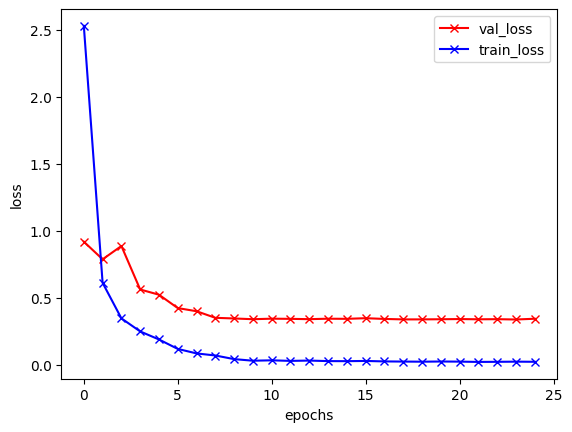

In [88]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

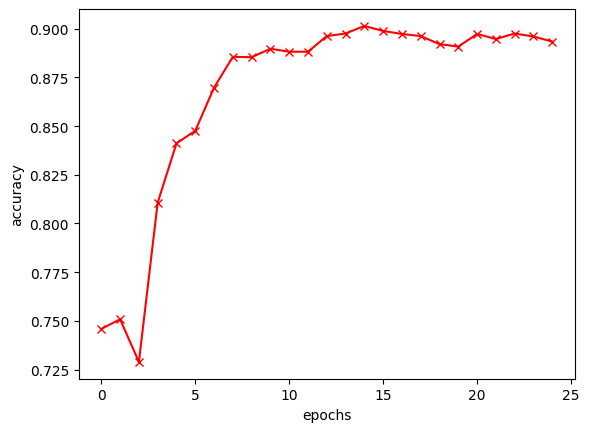

In [89]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

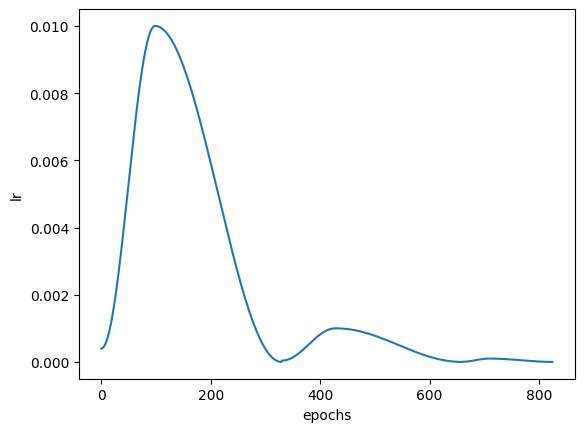

In [90]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

In [91]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model(xb)                   # change model object here
    predictions = preds[0]

    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

Actual : German shepherd  | Predicted : German shepherd


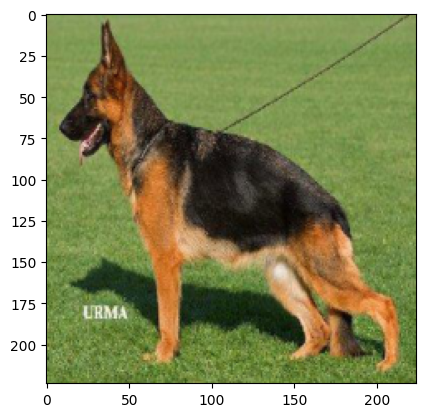

In [92]:
predict_single(*test_dataset[5])

Actual : Yorkshire terrier  | Predicted : Yorkshire terrier


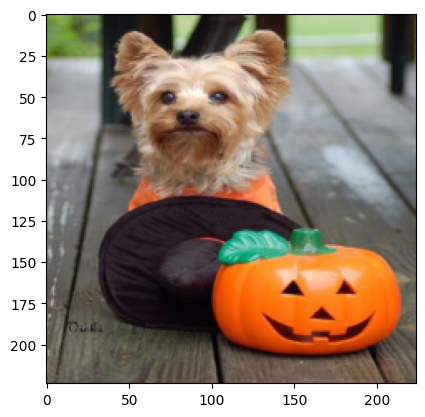

In [93]:
predict_single(*test_dataset[25])

Actual : Shih Tzu  | Predicted : Shih Tzu


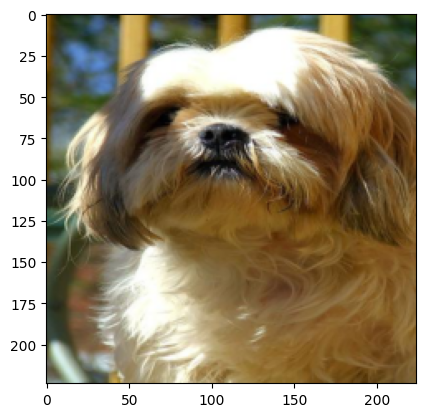

In [94]:
predict_single(*test_dataset[45])

In [95]:
test_dl = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_dl)
result

{'val_loss': 0.3206159472465515, 'val_acc': 0.8851739764213562}